# Heterogeneous Graph Neural Network (beta)

In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)

## Dataload

In [2]:
import pandas as pd

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 70)

playerFrames = pd.read_csv('../scrape-parse/demo/parse/2023/playerFrames/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv')

pf = playerFrames[['tick', 'roundNum', 'seconds', 'side', 'name', 'x', 'y', 'z',
    'eyeX', 'eyeY', 'eyeZ', 'velocityX', 'velocityY', 'velocityZ',
    'hp', 'armor', 'activeWeapon',
    'flashGrenades', 'smokeGrenades', 'heGrenades', 'totalUtility',
    'isAlive', 'isReloading', 'isDefusing', 'isPlanting', 'isUnknown',
    'equipmentValue', 'equipmentValueRoundStart', 'hasHelmet',
    'hasDefuse', 'hasBomb'
    ]]

rounds = pd.read_csv('../scrape-parse/demo/parse/2023/rounds/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv')
rounds = rounds[['roundNum', 'tScore', "ctScore" ,'endTScore', 'endCTScore']]

kills = pd.read_csv("../scrape-parse/demo/parse/2023/kills/blast-premier-fall-groups-2023-natus-vincere-vs-g2-bo3-qpKifIreD-H1wjvSAUFqcRnatus-vincere-vs-g2-m1-inferno.dem.csv")

pf = pf.merge(rounds, on='roundNum')
pf["winsRounds"] = pf.apply(lambda x: 
    1 if ( (x['side'] == 'T') and (x['endTScore'] > x['tScore']) ) or ( (x['side'] == 'CT') and (x['endCTScore'] > x['ctScore']) )
    else 0, axis=1)

pf['kills'] = 0
pf['deaths'] = 0

for index, row in kills.iterrows():
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['attackerName']), 'kills'] += 1
    pf.loc[(pf['tick'] >= row['tick']) & (pf['name'] == row['victimName']), 'deaths'] += 1

In [3]:
from math import floor

# Create dummie cols
dummies = pd.get_dummies(pf['activeWeapon'], prefix="activeWeapon",drop_first=False)[['activeWeapon_AK-47','activeWeapon_Knife','activeWeapon_AWP','activeWeapon_M4A1','activeWeapon_Smoke Grenade','activeWeapon_M4A4','activeWeapon_Galil AR','activeWeapon_Desert Eagle','activeWeapon_Flashbang','activeWeapon_Glock-18','activeWeapon_USP-S']]
dummies = dummies*1
pf = pf.merge(dummies, left_index = True, right_index = True, how = 'left')

# Rounded-down seconds
pf['floorSec'] = pf['seconds'].apply(lambda x: floor(x))
pf[['roundNum', 'floorSec', 'seconds']].iloc[30000:30500]

,roundNum,floorSec,seconds
30000,4,86,86.90625
30001,4,86,86.90625
30002,4,86,86.90625
30003,4,86,86.90625
30004,4,86,86.90625
...,...,...,...
30495,4,93,93.03125
30496,4,93,93.03125
30497,4,93,93.03125
30498,4,93,93.03125


C:\Users\szmid\AppData\Local\Temp\ipykernel_1612\37965649.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plotData['x'].head(10), plotData['y'].head(10), c='purple', cmap='viridis',s=2)
C:\Users\szmid\AppData\Local\Temp\ipykernel_1612\37965649.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(plotData['x'].iloc[10:20], plotData['y'].iloc[10:20], c='yellow', cmap='viridis',s=2)


(-1000.0, 4000.0)

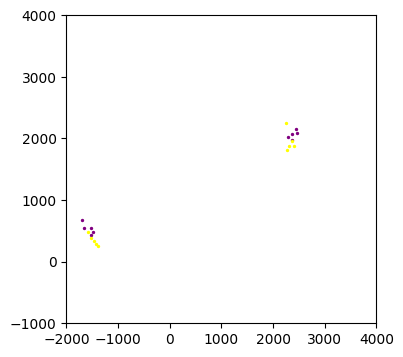

In [4]:
plotData = pf.drop_duplicates(subset=['floorSec', 'roundNum', 'name'])

plt.figure(figsize=(4,4))
plt.scatter(plotData['x'].head(10), plotData['y'].head(10), c='purple', cmap='viridis',s=2)
plt.scatter(plotData['x'].iloc[10:20], plotData['y'].iloc[10:20], c='yellow', cmap='viridis',s=2)
plt.xlim(-2000,4000)
plt.ylim(-1000,4000)

## Tasks

**A) Till this point**

The *secDf* dataframe contains the same information as *playerFrames*, but reduced to a second-by-second basis. 

**B) Next steps**

1. Separate the data to player-level and calculate player stats (kills, deaths in the match, etc.)
2. Check the nearest map-node for each player in each second
3. Copy / calculate graph-level features if nessesary (player alive on each side, remaining time, etc.), along with the target variable (win/loss)

### Player dataframes

In [6]:
# Calculate closest map-graph node
def find_closest(row):
    distances = np.sqrt((nodes['x'] - row['x'])**2 + (nodes['y'] - row['y'])**2)
    return nodes.loc[distances.idxmin(), 'nodeId']

# Separate team players, create empty object, read graph nodes
nodes = pd.read_csv('../graph/graph_models/manual/nodes_v1_4.csv')
startAsCTPlayerNames = pf[(pf['side'] == 'CT') & (pf['roundNum'] == 1)]['name'].unique()
startAsTPlayerNames = pf[(pf['side'] == 'T') & (pf['roundNum'] == 1)]['name'].unique()
players = {}

# Team 1: start on CT side
players[0] = pf[pf['name'] == startAsCTPlayerNames[0]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[1] = pf[pf['name'] == startAsCTPlayerNames[1]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[2] = pf[pf['name'] == startAsCTPlayerNames[2]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[3] = pf[pf['name'] == startAsCTPlayerNames[3]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[4] = pf[pf['name'] == startAsCTPlayerNames[4]].drop_duplicates(subset=['floorSec','roundNum']).copy()

# Team 2: start on T side
players[5] = pf[pf['name'] == startAsTPlayerNames[0]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[6] = pf[pf['name'] == startAsTPlayerNames[1]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[7] = pf[pf['name'] == startAsTPlayerNames[2]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[8] = pf[pf['name'] == startAsTPlayerNames[3]].drop_duplicates(subset=['floorSec','roundNum']).copy()
players[9] = pf[pf['name'] == startAsTPlayerNames[4]].drop_duplicates(subset=['floorSec','roundNum']).copy()

for idx, player in enumerate(players):
    
    players[idx] = players[idx].replace(True, 1)
    players[idx] = players[idx].replace(False, 0)
    players[idx]['isCT'] = players[idx]['side'].apply(lambda x: 1 if x == 'CT' else 0)
    players[idx]['closestId'] = players[idx].apply(find_closest, axis=1)

    del players[idx]['side']
    del players[idx]['activeWeapon']
    del players[idx]['winsRounds']

In [7]:
players[0]

,tick,roundNum,seconds,name,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,kills,deaths,activeWeapon_AK-47,activeWeapon_Knife,activeWeapon_AWP,activeWeapon_M4A1,activeWeapon_Smoke Grenade,activeWeapon_M4A4,activeWeapon_Galil AR,activeWeapon_Desert Eagle,activeWeapon_Flashbang,activeWeapon_Glock-18,activeWeapon_USP-S,floorSec,isCT,closestId
0,9648,1,0.078125,Aleksib,2291.713867,2031.145874,128.031250,2291.713867,2031.145874,192.093811,-7.701770,77.791405,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,155
81,9776,1,1.078125,Aleksib,2257.619873,2250.425293,128.031250,2257.619873,2250.425293,192.093811,-119.223747,218.292725,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,150
160,9904,1,2.078125,Aleksib,2139.303467,2464.421875,128.031250,2139.303467,2464.421875,192.093811,-133.440170,209.520645,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,1,153
240,10032,1,3.078125,Aleksib,1984.614868,2656.071533,128.031250,1984.614868,2656.071533,192.093811,-201.938309,147.380188,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,1,154
323,10160,1,4.078125,Aleksib,1755.860107,2754.217285,127.873169,1755.860107,2754.217285,191.935730,-235.700089,48.875271,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,4,1,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260768,569555,30,98.023438,Aleksib,1808.623657,-73.985199,129.338638,2115.815674,-345.349792,131.076218,58.659725,-16.911407,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,98,0,173
260849,569683,30,99.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.831177,701.907715,224.093811,-1.382732,-0.726303,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,99,0,173
260925,569811,30,100.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.679077,701.828247,206.076218,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,100,0,173
261008,569939,30,101.023438,Aleksib,1808.623657,-73.985199,129.338638,1947.679077,701.828247,206.076218,0.000000,0.000000,0.0,0,0,0,0,0,0,0,0,0,0,0,2600,200,0,0,0,15,14,16,14,18,20,0,0,0,0,0,0,0,0,0,0,0,101,0,173


### Player-edges dataframe

In [8]:
playerEdges = None

for idx in range(0,len(players)):
    temp = players[idx][['roundNum','floorSec','closestId']].copy()
    temp['playerId'] = idx
    if playerEdges is None:
        playerEdges = temp
    else:
        playerEdges = pd.concat([playerEdges, temp])

In [9]:
playerEdges

,roundNum,floorSec,closestId,playerId
0,1,0,155,0
81,1,1,150,0
160,1,2,153,0
240,1,3,154,0
323,1,4,138,0
...,...,...,...,...
260761,30,98,163,9
260844,30,99,164,9
260921,30,100,163,9
261000,30,101,162,9


### Graph-level dataframe

In [10]:
# Copy players object
graph_players = {}
for idx in range(0,len(players)):
    graph_players[idx] = players[idx].copy()

colsNotToRename = ['tick', 'roundNum', 'seconds', 'floorSec']

# Rename columns except for tick, roundNum, seconds, floorSec
for idx in range(0,len(graph_players)):
    
    for col in graph_players[idx].columns:
        if col not in colsNotToRename:
            graph_players[idx].rename(columns={col: "player" + str(idx) + "_" + col}, inplace=True)

# Create a graph dataframe to store all players in 1 row per second
graph_data = graph_players[0].copy()

# Merge dataframes
for i in range(1, len(graph_players)):
    graph_data = graph_data.merge(graph_players[i], on=colsNotToRename)
    
graph_data = graph_data.merge(rounds, on=['roundNum'])
graph_data['CTwinsRound'] = graph_data.apply(lambda x: 
    1 if 
    (x['endCTScore'] > x['ctScore'])
    else 0, axis=1)
graph_data['team1AliveNum'] = graph_data[['player0_isAlive','player1_isAlive','player2_isAlive','player3_isAlive','player4_isAlive']].sum(axis=1)
graph_data['team2AliveNum'] = graph_data[['player5_isAlive','player6_isAlive','player7_isAlive','player8_isAlive','player9_isAlive']].sum(axis=1)
graph_data = graph_data[['roundNum','seconds','floorSec','team1AliveNum','team2AliveNum','CTwinsRound']]
graph_data

,roundNum,seconds,floorSec,team1AliveNum,team2AliveNum,CTwinsRound
0,1,0.078125,0,5,5,0
1,1,1.078125,1,5,5,0
2,1,2.078125,2,5,5,0
3,1,3.078125,3,5,5,0
4,1,4.078125,4,5,5,0
...,...,...,...,...,...,...
2715,30,98.023438,98,3,3,0
2716,30,99.023438,99,3,3,0
2717,30,100.023438,100,3,3,0
2718,30,101.023438,101,3,3,0


In [11]:
[k for k in graph_data.columns if 'player1' in k]

[]

## Heterogeneous Graph Neural Network model

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import HeteroData, DataLoader
from torch_geometric.nn import RGCNConv
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, to_hetero


In [176]:
from sklearn.preprocessing import MinMaxScaler

nodes = pd.read_csv('../graph/graph_models/manual/nodes_v1_4.csv')
edges = pd.read_csv('../graph/graph_models/manual/edges_v1_4.csv')

edges.replace(200,160,inplace=True)
edges.replace(201,161,inplace=True)
edges.replace(202,162,inplace=True)
edges.replace(203,163,inplace=True)
edges.replace(204,164,inplace=True)
edges.replace(205,165,inplace=True)
edges.replace(206,166,inplace=True)
edges.replace(207,167,inplace=True)
edges.replace(208,168,inplace=True)
edges.replace(209,169,inplace=True)
edges.replace(210,170,inplace=True)
edges.replace(211,171,inplace=True)
edges.replace(212,172,inplace=True)
edges.replace(213,173,inplace=True)
edges.replace(214,174,inplace=True)
edges.replace(215,175,inplace=True)
edges.replace(216,176,inplace=True)
edges.replace(217,177,inplace=True)
edges.replace(218,178,inplace=True)
edges.replace(219,179,inplace=True)
edges.replace(220,180,inplace=True)

playerFrameData = pd.DataFrame(columns=players[0].columns)
playerFrameData1 = pd.DataFrame(columns=players[0].columns)
for idx in range(0,len(players)):
    playerFrameData.loc[idx] = players[idx].iloc[0]
    playerFrameData1.loc[idx] = players[idx].iloc[1]
    
playerFrameData.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)
playerFrameData1.drop(columns=['tick', 'roundNum', 'seconds', 'name', 'closestId'], inplace=True)

playerFrameData

,x,y,z,eyeX,eyeY,eyeZ,velocityX,velocityY,velocityZ,hp,armor,flashGrenades,smokeGrenades,heGrenades,totalUtility,isAlive,isReloading,isDefusing,isPlanting,isUnknown,equipmentValue,equipmentValueRoundStart,hasHelmet,hasDefuse,hasBomb,tScore,ctScore,endTScore,endCTScore,kills,deaths,activeWeapon_AK-47,activeWeapon_Knife,activeWeapon_AWP,activeWeapon_M4A1,activeWeapon_Smoke Grenade,activeWeapon_M4A4,activeWeapon_Galil AR,activeWeapon_Desert Eagle,activeWeapon_Flashbang,activeWeapon_Glock-18,activeWeapon_USP-S,floorSec,isCT
0,2291.713867,2031.145874,128.03125,2291.713867,2031.145874,192.093811,-7.70177,77.791405,0.0,100,0,0,0,0,0,1,0,0,0,0,400,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
1,2432.86792,2154.028809,128.03125,2432.86792,2154.028809,192.093811,-16.776962,-75.470238,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
2,2468.637451,2090.973389,132.03125,2468.637451,2090.973389,196.093811,-25.949188,-73.739265,0.0,100,100,0,0,0,0,1,0,0,0,0,950,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
3,2364.960449,2070.991455,128.03125,2364.960449,2070.991455,192.093811,-50.349201,-49.604195,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
4,2363.165283,1982.37146,128.03125,2363.165283,1982.37146,192.093811,0.165435,-73.868225,0.0,100,0,1,1,0,2,1,0,0,0,0,1100,200,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
5,-1706.147461,671.062134,-48.96875,-1706.147461,671.062134,15.093811,41.695408,-66.123642,0.0,100,0,0,1,0,2,1,0,0,0,0,550,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6,-1654.269775,542.00592,-63.219006,-1654.269775,542.00592,0.843555,61.392929,-44.83828,0.0,100,100,1,0,0,1,1,0,0,0,0,1050,200,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,-1490.573364,487.386139,-63.96875,-1490.573364,487.386139,0.093811,19.524948,-64.333504,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,-1517.924072,428.1521,-65.523895,-1517.924072,428.1521,-1.461334,48.071106,-61.644241,0.0,100,100,1,0,0,1,1,0,0,0,0,1050,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,-1531.067505,540.81665,-63.344318,-1531.067505,540.81665,0.718243,-16.987856,-70.272469,0.0,100,100,0,0,0,0,1,0,0,0,0,850,200,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [178]:
playerFrameData = playerFrameData.astype('float32')
playerFrameData1 = playerFrameData1.astype('float32')

In [171]:
# # Create the heterogeneous graph
# data = HeteroData()

# data["map"].x = torch.tensor(nodes[['x','y']].values)
# data["player"].x = torch.tensor(playerFrameData.values)

# data["map", "connected_to", "map"].edge_index = torch.tensor(edges.values)
# data["player", "closest_to", "map"].edge_index = torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == 1) & (playerEdges['floorSec'] == 0)][['playerId','closestId']].values)

# data['graph_attr'] = torch.tensor(graph_data[['roundNum','floorSec','team1AliveNum','team2AliveNum']].iloc[0])
# data['y'] = torch.tensor(graph_data['CTwinsRound'].iloc[0])

In [179]:
# Change nodes x and y dtype to float in the original nodes dataframe
nodes['x'] = nodes['x'].astype('float32')
nodes['y'] = nodes['y'].astype('float32')

# edges['source'] = edges['source'].astype('float64')
# edges['target'] = edges['target'].astype('float64')

In [186]:
# Create a sample heterogeneous graph with node, edge, and multiple graph-level features
node_features = {
    'map': torch.tensor(nodes[['x','y']].values),
    'player': torch.tensor(playerFrameData.values)  # Different feature size for 'node_type2'
}

edge_index = {
    ('map', 'connected_to', 'map'): torch.tensor(edges.values),
    ('player', 'closest_to', 'map'): torch.tensor(playerEdges.loc[ (playerEdges['roundNum'] == 1) & (playerEdges['floorSec'] == 0)][['playerId','closestId']].values)
}

# Define multiple graph-level features
graph_level_features = {
    'roundNum': torch.tensor(graph_data['roundNum'].iloc[0].astype('float64')),
    'floorSec': torch.tensor(graph_data['floorSec'].iloc[0].astype('float64')),
    'team1AliveNum': torch.tensor(graph_data['team1AliveNum'].iloc[0].astype('float64')),
    'team2AliveNum': torch.tensor(graph_data['team2AliveNum'].iloc[0].astype('float64')),
}

# Convert the data to PyTorch Geometric HeteroData format
data = HeteroData(
    x=node_features,
    edge_index=edge_index,
    y=torch.tensor(graph_data['CTwinsRound'].iloc[0]),
    **graph_level_features  # Include multiple graph-level features
)

In [220]:
#data['x']['map'].shape
data['x']['player'].shape

torch.Size([10, 44])

In [202]:
data['edge_index'][('player', 'closest_to', 'map')].shape
#data['edge_index'][('map', 'connected_to', 'map')].T.shape

torch.Size([10, 2])

In [231]:
from torch_geometric.nn import HeteroConv, Linear, SAGEConv, GCNConv


class HeteroGNN(torch.nn.Module):

    def __init__(self, node_input_dims, graph_feature_dims, hidden_dim):
        super(HeteroGNN, self).__init__()
        self.conv1_type1 = GCNConv(node_input_dims['map'], hidden_dim)
        self.conv1_type2 = GCNConv(node_input_dims['player'], hidden_dim)
        self.conv2_type1 = GCNConv(hidden_dim, hidden_dim)
        self.fc = Linear(hidden_dim + graph_feature_dims, 1)  # Output dimension is 1 for binary classification

    def forward(self, x, edge_index, graph_level_features):
        print(edge_index[('player', 'closest_to', 'map')].shape)
        x_type1 = self.conv1_type1(x['map'], edge_index[('map', 'connected_to', 'map')].T)
        print("firstConvDone")
        x_type2 = self.conv1_type2(x['player'], edge_index[('player', 'closest_to', 'map')])
        print("secondConvDone")

        x_type1 = torch.relu(x_type1)
        x_type2 = torch.relu(x_type2)

        x_type1 = self.conv2_type1(x_type1, edge_index[('map', 'connected_to', 'map')])

        # Aggregating information from nodes and edges
        graph_level_representation = torch.mean(x_type1, dim=0)  # You can use different aggregation methods
        graph_level_representation = torch.cat([
            graph_level_representation,
            graph_level_features['roundNum'],
            graph_level_features['floorSec'],
            graph_level_features['team1AliveNum'],
            graph_level_features['team2AliveNum'],
        ],dim=-1)

        graph_level_prediction = self.fc(graph_level_representation)
        return graph_level_prediction


In [230]:
from torch.nn import BCEWithLogitsLoss

# Instantiate the model
node_input_dims = {'map': 2, 'player': 44}
graph_feature_dims = 4  # Total dimensions of graph-level features
model = HeteroGNN(node_input_dims=node_input_dims, graph_feature_dims=graph_feature_dims, hidden_dim=64)

# Define binary cross-entropy loss and optimizer
criterion = BCEWithLogitsLoss()  # Binary cross-entropy loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(2):
    optimizer.zero_grad()
    graph_level_prediction = model(data['x'], data['edge_index'], data.y)
    loss = criterion(graph_level_prediction, data.y.view(-1, 1))  # Reshape y for BCE loss
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch + 1}, Loss: {loss.item()}')


torch.Size([10, 2])
firstConvDone


RuntimeError: index 155 is out of bounds for dimension 0 with size 44

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['player'].train_mask
    loss = F.cross_entropy(out[mask], data['player'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)